In [12]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedShuffleSplit

In [13]:
# Load the dataset
df = pd.read_csv("../data/cleaned_data.csv", low_memory = False)

In [14]:
# Assuming your DataFrame is called df and the target column is 'target'
# Replace 'target' with the name of your target column

X = df.drop('loan_status', axis=1)  # Features
y = df['loan_status']  # Target variable

In [15]:
# Instantiate StratifiedShuffleSplit with n_splits=1
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=42)

# Split data into train and test
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Further split test data into validation and test
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(sss_val_test.split(X_test, y_test))
X_val, X_test = X_test.iloc[val_index], X_test.iloc[test_index]
y_val, y_test = y_test.iloc[val_index], y_test.iloc[test_index]

# Now we have X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
eval_set = [(X_val, y_val)]

In [18]:
experiment_name = "XGBoost_Hyperparameter_Tuning"
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/furka/PycharmProjects/Credit_Risk/mlruns/389901588864882854', creation_time=1710623022464, experiment_id='389901588864882854', last_update_time=1710623022464, lifecycle_stage='active', name='XGBoost_Hyperparameter_Tuning', tags={}>

In [19]:
clf = xgb.sklearn.XGBClassifier(
    objective="binary:logistic",
    seed=7777,
    eval_metric='auc',
    early_stopping_rounds=20)

In [20]:
param_space = {
    "learning_rate": [0.01, 0.03, 0.04, 0.05, 0.1],
    "max_depth": [ 5, 7, 8, 9, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "gamma": [ 0.5, 0.75, 1],
    "n_estimators": [300, 400, 500]
    }

In [21]:
bayes_search = BayesSearchCV(clf, search_spaces=param_space, n_iter=100, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

In [22]:
with mlflow.start_run():
    bayes_search.fit(X_train, y_train, eval_set=eval_set, verbose=True)

    # Log parameters
    for param, value in bayes_search.best_params_.items():
        mlflow.log_param(param, value)

    # Log metrics
    mlflow.log_metric("best_roc_auc", bayes_search.best_score_)

    # Evaluate model on test set
    y_pred_proba = bayes_search.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    feature_importance = bayes_search.best_estimator_.feature_importances_
    for i, importance in enumerate(feature_importance):
        mlflow.log_metric(f"feature_{i}_importance", importance)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [23]:
# Log dataset
mlflow.log_artifact('../data/cleaned_data.csv', artifact_path='datasets')

In [24]:
# Log model
mlflow.xgboost.log_model(bayes_search.best_estimator_, "xgboost_model")

C:\Users\furka\PycharmProjects\Credit_Risk\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:18:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


## ROC_AUC Curve plotting

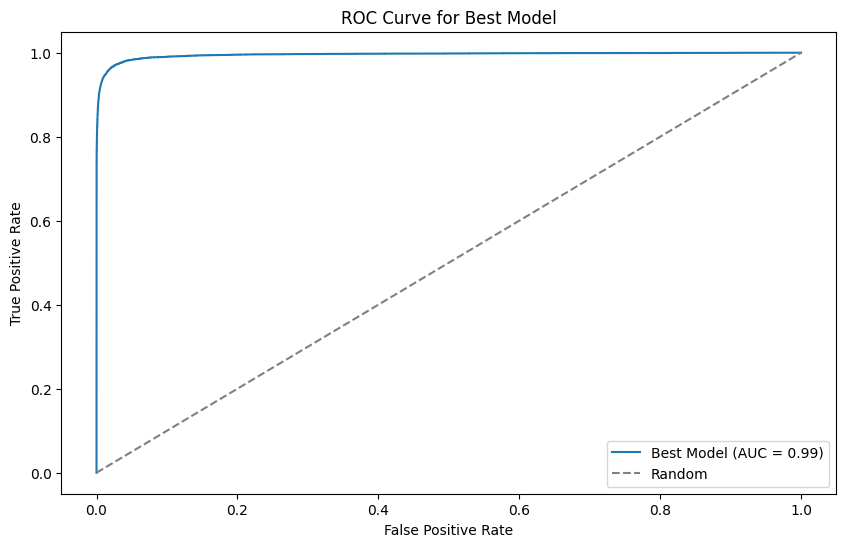

In [25]:
# Prepare ROC AUC Curve
all_roc_auc_scores = bayes_search.cv_results_['mean_test_score']

# Find the index of the top-performing model
best_index = np.argmax(all_roc_auc_scores)
best_params = bayes_search.cv_results_['params'][best_index]
best_roc_auc = all_roc_auc_scores[best_index]

# Plot ROC curve for the best model
plt.figure(figsize=(10, 6))
model = xgb.sklearn.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Best Model (AUC = {best_roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend()

# Save plot as image
plot_path = "best_roc_curve_plot.png"
plt.savefig(plot_path)

# Log plot as artifact in MLflow
mlflow.log_artifact(plot_path, "plots")

## Feature importance plotting

In [26]:
feature_importance = bayes_search.best_estimator_.feature_importances_

In [27]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance, tick_label=X.columns)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Save plot as image
feature_importance_plot_path = "feature_importance_plot.png"
plt.savefig(feature_importance_plot_path)

# Log plot as artifact in MLflow
mlflow.log_artifact(feature_importance_plot_path, "plots")

# Close plot
plt.close()

In [28]:
mlflow.end_run()